In [1]:
import torch

import torchvision
import torchvision.transforms as transforms

In [2]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

dev

device(type='cuda')

In [7]:
transform_train = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     # transforms Normalize ( (R_mean, G_mean, B_mean), (R_std, G_std, B_std) )
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     # transforms Normalize ( (R_mean, G_mean, B_mean), (R_std, G_std, B_std) )
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 124

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(trainset)

print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [6]:
data = iter(trainloader)
x, y = data.next()
print(x.shape)

torch.Size([124, 3, 32, 32])


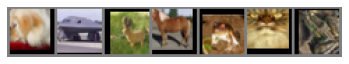

  dog plane  deer horse  frog   cat  frog


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('Off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:7]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(7)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class convModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Conv2D(in_channels, out_channels, kernel_size, ...)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.batchnorm3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, 3)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, 3)
        self.batchnorm5 = nn.BatchNorm2d(128)
        
        # MaxPool2D(kernel_size, stride, ...)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.4)
        
        self.fc1 = nn.Linear(4 * 4 * 128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 84)
        self.fc4 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))               # 32 filtros
        x = F.relu(self.batchnorm2(self.conv2(x)))               # 64 filtros
        x = self.maxpool(self.batchnorm3(self.conv3(x)))        # 128 filtros
        x = F.relu(x)

        x = F.relu(self.batchnorm4(self.conv4(x)))               # 128 filtros
        x = self.maxpool(self.batchnorm5(self.conv5(x)))        # 128 filtros
        x = F.relu(x)
        
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)            # 40%

        x = F.relu(self.fc2(x))
        x = self.dropout1(x)

        x = F.relu(self.fc3(x))
        x = self.dropout1(x)

        x = self.fc4(x)
        
        return x

In [8]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(len(testloader))
print(len(trainloader))

81
404


In [9]:
def density(net):
    non_zero = 0
    count = 0
    with torch.no_grad():
        for p in net.parameters():
            #flatted_weights = torch.flatten(p)
            non_zero += torch.count_nonzero(p).cpu().numpy()
            count += torch.numel(p)

    #print("non zero: ", non_zero)
    #print("count: ", count)
    return non_zero / count


In [10]:
def pruning(model, gamma):
    if gamma > 0.0:
        with torch.no_grad():
            betas = []
            for p in model.parameters():
                # transformando o layer em um vetor unidimensional 
                flatted_weights = torch.flatten(p)

                # calculando o desvio padrao
                std = torch.std(flatted_weights, -1)

                # calculando o beta para a camada
                beta = gamma * std                        
                betas.append(beta)
                
                # mascara booleana, que indica qual peso devera ser mantido
                mask = torch.gt(p.abs(), torch.ones_like(p) * beta)
                
                # multiplicando os pesos da camada pelo tensor booleano
                p.multiply_(mask)
                #print(p)
                #p[torch.logical_not(boolean)] = 0

    return betas

In [11]:
def quantization(model, b, betas=[]):
    if b >= 1:
        if len(betas) > 0:
            with torch.no_grad():
                for p, beta in zip(model.parameters(), betas):
                    flatted_weights = torch.flatten(p)
        
                    # calculando o desvio padrao
                    #std = torch.std(flatted_weights, -1)
        
                    # calculando o beta para a camada
                    #beta = gamma * std                        
                    #beta = 0.0;
                    qk_prime = (torch.max(torch.abs(flatted_weights)) - beta) / ( (2**(b - 1)) - 1 )
                    #previous = p.clone().detach();
                    #print("ANTES --------------------") 
                    #print(previous[0])
                    torch.round(p/qk_prime, out=p)
        
                    p.multiply_(qk_prime)
                    #print("DEPOIS --------------------") 
                    #print(p[0])
                    """
                    isnan = torch.isnan(p).any()
                    if isnan:
                        print("NAN WEIGHT")
                        print(p.shape)
                        print(p)
                    """

        else:
            with torch.no_grad():
                for p in model.parameters():
                    flatted_weights = torch.flatten(p)
                    beta = 0.0;
                    qk_prime = (torch.max(torch.abs(flatted_weights)) - beta) / ( (2**(b - 1)) - 1 )
                    torch.round(p/qk_prime, out=p)
                    p.multiply_(qk_prime)

In [14]:
# fit pruning
# return list of loss, acc

# SALVANDO OS SCORES                               <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< PRUNING ACC.
#                                                                                           METRIC
scores = []

def fit_pruning(net, epochs, optimizer, gamma, b, learning_rate, loss_fn, train_dl, test_dl):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    densities = []
    skip = 105
    count = 1
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        test_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0


        #values_set = set()

        net.train()
        model_copy = type(net)() # get a new instance
        model_copy.to(dev)
        # TRAIN
        for i, data in enumerate(train_dl):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(dev), data[1].to(dev)

            # >>> PRUNING <<<
            if gamma>0.0:
                betas = pruning(net, gamma)

            # copiando os pesos
            model_copy.load_state_dict(net.state_dict())
            pesos_pruned = list(model_copy.parameters())

            # >>> QUANTIZATION <<<
            if b>0:
                quantization(net, b, betas)

            # forward
            outputs = net(inputs)
            
            # loss calculation
            loss = loss_fn(outputs, labels)
            
            # loss backward. grads are generated here
            loss.backward()
            
            if b>0 and gamma>0.0:
                with torch.no_grad():
                    for p_net, p_pruning in zip(net.parameters(), pesos_pruned):
                        #p_pruning.subtract(p_net.grad * 0.05)
                        #pesos = pesos_pruning - learning_rate*p_net.grad
                        torch.subtract(p_pruning, p_net.grad * learning_rate, out=p_net)
                    net.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
            # update weights
            #optimizer.step()

            # reset gradients
            #optimizer.zero_grad()

            #print("loss: ", loss.clone().detach())
                
            train_loss += loss.item()  
            train_acc += accuracy(outputs, labels).item()

        # >>> PRUNING <<<
        if b>0 and gamma>0.0:
            betas = pruning(net, gamma)

            quantization(net, b, betas)

        net.eval()

        # TEST
        for i, data in enumerate(test_dl):
            inputs, labels = data[0].to(dev), data[1].to(dev)

            with torch.no_grad():
                outputs = net(inputs)
            test_loss += loss_fn(outputs, labels).item()
            test_acc += accuracy(outputs, labels).item()
            
        train_loss /= len(train_dl)
        train_acc /= len(train_dl)
        test_loss /= len(test_dl)
        test_acc /= len(test_dl)
        dst = density(net)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        densities.append(density(net))
        
        print('Epoch: %d/%d \
               train loss: %.3f \
               train accuracy: %.3f \
               test accuracy: %.3f \
               density: %.3f' %
            (epoch + 1, epochs, train_loss, train_acc, test_acc, dst)) # 782 == total of train batches
        

    print('Finished Training')
    return train_losses, train_accuracies, test_losses, test_accuracies, densities

In [15]:
def init_weights(m):
    try:
        m.bias.data.fill_(0.1)
    except: pass


In [ ]:
import torch.nn.functional as F
from torch import optim

lr = 0.075

loss_func = F.cross_entropy
model_cu = convModel()
model_cu.to(dev)
model_cu.apply(init_weights)
#opt = optim.SGD(model_cu.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model_cu.parameters(), lr=lr)


#def fit_pruning(net, optimizer, epochs, gamma, b, pruning_rate, loss_fn, train_dl, test_dl):
running_loss, _, _, running_test_acc, densities = fit_pruning(model_cu, 160, opt, 0.5, 4, lr, loss_func, trainloader, testloader)

print("")

In [ ]:
# Plot training loss over epochs

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

NameError: ignored

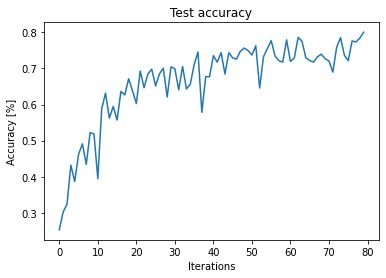

In [ ]:
# Plot test accuracy over epochs

acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

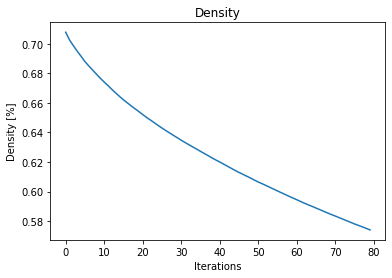

In [ ]:
# Plot test accuracy over epochs
density_per_epoch = [np.mean(dnst) for dnst in densities]
display_loss_plot(density_per_epoch, title="Density", ylabel="Density [%]")

In [ ]:
import torch.onnx 

#Function to Convert to ONNX 
def Convert_ONNX(): 

    # set the model to inference mode 
    model.eval() 

    # Let's create a dummy input tensor  
    dummy_input = torch.randn(1, input_size, requires_grad=True)  

    # Export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "convnet.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['modelInput'],   # the model's input names 
         output_names = ['modelOutput'], # the model's output names 
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                                'modelOutput' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX') 

In [ ]:
import pandas as pd

def save_experiment(net, log, parameters):
    train_losses, train_accuracies, test_losses, test_accuracies, densities = log
    net_name = 'gamma' + parameters['gamma'] + 'acc' + str(max(test_accuracies).cpu().numpy())[:4] + 'dst' + str(min(densities))[:4]


    df = pd.DataFrame({
        'loss': train_losses,
        'test_accuracy': list(map(lambda x: x.cpu().numpy(), test_accuracies)),
        'density': densities
    })

    df['epoch'] = range(1, len(train_losses) + 1)
    df.to_csv(net_name + '.csv')

    torch.save(net, net_name + '.pth')

save_experiment(net_p05, data, {'gamma': '1.0'})

In [ ]:
#torch.save(net_nopruning, './models/no_pruning/model.pth')
print(density(net_p05))
torch.save(net_p05, './pruning_gamma05.pth')


#torch.save(net_p10, './models/pruning_gamma10/model.pth')

#torch.save(net_p15, './models/pruning_gamma15/model.pth')

non zero:  tensor(42162, device='cuda:0')
count:  1591270
tensor(0.0265, device='cuda:0')


In [ ]:
import matplotlib.pyplot as plt

